In [3]:
import logging.config
import os

from typing import List
from typing import Tuple

import numpy as np
import pandas as pd
import requests

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from lightautoml.spark.automl.presets.tabular_presets import SparkTabularAutoML
from lightautoml.spark.dataset.base import SparkDataFrame
from lightautoml.spark.dataset.base import SparkDataset
from lightautoml.spark.tasks.base import SparkTask
from lightautoml.spark.utils import VERBOSE_LOGGING_FORMAT
from lightautoml.spark.utils import log_exec_timer
from lightautoml.spark.utils import logging_config

In [4]:
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.ERROR)

In [5]:
def prepare_test_and_train(spark: SparkSession, path:str, seed: int) -> Tuple[SparkDataFrame, SparkDataFrame]:
    data = spark.read.csv(path, header=True, escape="\"")

    data = data.select(
        '*',
        F.monotonically_increasing_id().alias(SparkDataset.ID_COLUMN),
        F.rand(seed).alias('is_test')
    ).cache()
    data.write.mode('overwrite').format('noop').save()

    train_data = data.where(F.col('is_test') < 0.8).drop('is_test').cache()
    test_data = data.where(F.col('is_test') >= 0.8).drop('is_test').cache()

    train_data.write.mode('overwrite').format('noop').save()
    test_data.write.mode('overwrite').format('noop').save()

    return train_data, test_data

In [6]:
def get_spark_session():
    if os.environ.get("SCRIPT_ENV", None) == "cluster":
        return SparkSession.builder.getOrCreate()

    spark_sess = (
        SparkSession
        .builder
        .master("local[10]")
        .config("spark.jars", "../../jars/spark-lightautoml_2.12-0.1.jar")
        .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5")
        .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")
        .config("spark.sql.shuffle.partitions", "16")
        .config("spark.driver.memory", "12g")
        .config("spark.executor.memory", "12g")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .getOrCreate()
    )

    return spark_sess

In [7]:
spark = get_spark_session()
spark.sparkContext.setLogLevel("ERROR")

22/03/21 13:53:15 WARN Utils: Your hostname, desktop resolves to a loopback address: 127.0.1.1; using 192.168.0.104 instead (on interface wlp7s0)
22/03/21 13:53:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/azamat/.ivy2/cache
The jars for the packages stored in: /home/azamat/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e1ba39f2-ad81-4f9f-9273-c056eb9fa717;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/azamat/projects/LightAutoML/.venv/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.microsoft.azure#synapseml_2.12;0.9.5 in central
	found com.microsoft.azure#synapseml-core_2.12;0.9.5 in central
	found org.scalactic#scalactic_2.12;3.0.5 in central
	found org.scala-lang#scala-reflect;2.12.4 in central
	found io.spray#spray-json_2.12;1.3.2 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents#httpclient;4.5.6 in central
	found org.apache.httpcomponents#httpcore;4.4.10 in central
	found commons-logging#commons-logging;1.2 in central
	found commons-codec#commons-codec;1.10 in central
	found org.apache.httpcomponents#httpmime;4.5.6 in central
	found com.linkedin.isolation-forest#isolation-forest_3.2.0_2.12;2.0.8 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found org.typelevel#macro-compat_2.12;1.1.1 in central
	found org.apache.spark#spark-avro_2.12;3.2.0 in central
	found org.tukaani#xz;1.8 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.testng#testng;6.8.8 in central
	found org.bean

22/03/21 13:53:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/21 13:53:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/03/21 13:53:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [8]:
seed = 42
cv = 2
use_algos = [["lgb"]]
task_type = "multiclass"
path = "/opt/spark_data/ipums_97.csv"
metric_name = "crossentropy"
roles = {"target": "movedin"}

train_data, test_data = prepare_test_and_train(spark, path, seed)

task = SparkTask(task_type, metric=metric_name)

automl = SparkTabularAutoML(
    spark=spark,
    task=task,
    lgb_params={'use_single_dataset_mode': True},
    general_params={"use_algos": use_algos},
    reader_params={"cv": cv, "advanced_roles": False, 'random_state': seed}
)

automl.fit_predict(train_data, roles)

features pipeline ctr
lama advanced pipeline ctr
features pipeline ctr
i am here


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 58
[LightGBM] [Info] Start training from score -2,550734
[LightGBM] [Info] Start training from score -1,976805
[LightGBM] [Info] Start training from score -3,330059
[LightGBM] [Info] Start training from score -2,166909
[LightGBM] [Info] Start training from score -2,021727
[LightGBM] [Info] Start training from score -1,307188
[LightGBM] [Info] Start training from score -1,685254
[LightGBM] [Info] Start training from score -3,106916


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,004103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2783
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 68
[LightGBM] [Info] Start training from score -2,550734
[LightGBM] [Info] Start training from score -1,976805
[LightGBM] [Info] Start training from score -3,330059
[LightGBM] [Info] Start training from score -2,166909
[LightGBM] [Info] Start training from score -2,021727
[LightGBM] [Info] Start training from score -1,307188
[LightGBM] [Info] Start training from score -1,685254
[LightGBM] [Info] Start training from score -3,106916


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,003486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 2885, number of used features: 68
[LightGBM] [Info] Start training from score -2,551180
[LightGBM] [Info] Start training from score -1,901172
[LightGBM] [Info] Start training from score -3,266800
[LightGBM] [Info] Start training from score -2,048386
[LightGBM] [Info] Start training from score -2,174267
[LightGBM] [Info] Start training from score -1,286426
[LightGBM] [Info] Start training from score -1,750674
[LightGBM] [Info] Start training from score -3,171490


SparkDataset (DataFrame[movedin: int, reader_fold_num: bigint, _id: bigint, prediction_Lvl_0_Pipe_0_Mod_0_LightGBM: vector])

In [9]:
automl.reader._roles

{'gq': Category role, dtype <class 'object'>. Additional params: [('encoding_type', 'auto'), ('unknown', 5), ('force_input', False), ('label_encoded', False), ('ordinal', False)],
 'gqtypeg': Category role, dtype <class 'object'>. Additional params: [('encoding_type', 'auto'), ('unknown', 5), ('force_input', False), ('label_encoded', False), ('ordinal', False)],
 'farm': Category role, dtype <class 'object'>. Additional params: [('encoding_type', 'auto'), ('unknown', 5), ('force_input', False), ('label_encoded', False), ('ordinal', False)],
 'ownershg': Category role, dtype <class 'object'>. Additional params: [('encoding_type', 'auto'), ('unknown', 5), ('force_input', False), ('label_encoded', False), ('ordinal', False)],
 'value': Numeric role, dtype <class 'numpy.float32'>. Additional params: [('force_input', False), ('prob', False), ('discretization', False)],
 'rent': Numeric role, dtype <class 'numpy.float32'>. Additional params: [('force_input', False), ('prob', False), ('discre

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:05<00:00, 15.67s/it]


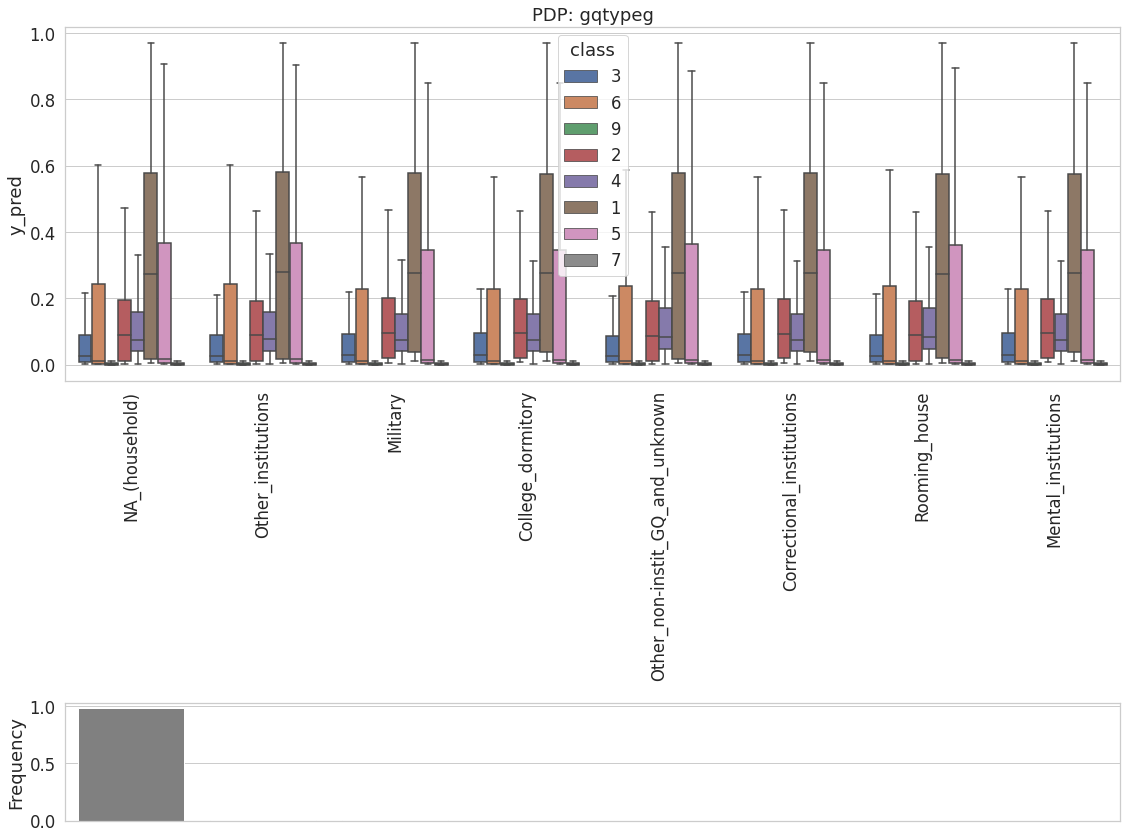

In [10]:
automl.plot_pdp(test_data, feature_name='gqtypeg')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [07:55<00:00, 15.86s/it]


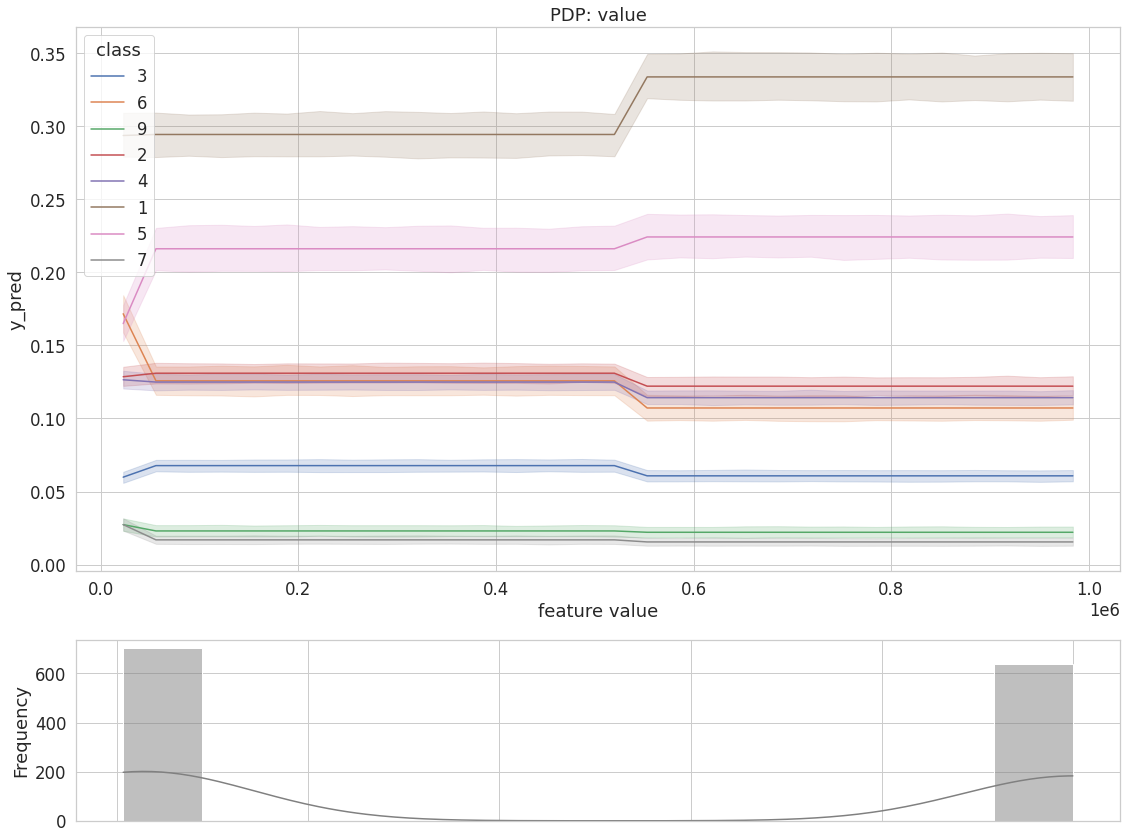

In [11]:
automl.plot_pdp(test_data, feature_name='value')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [07:52<00:00, 15.76s/it]


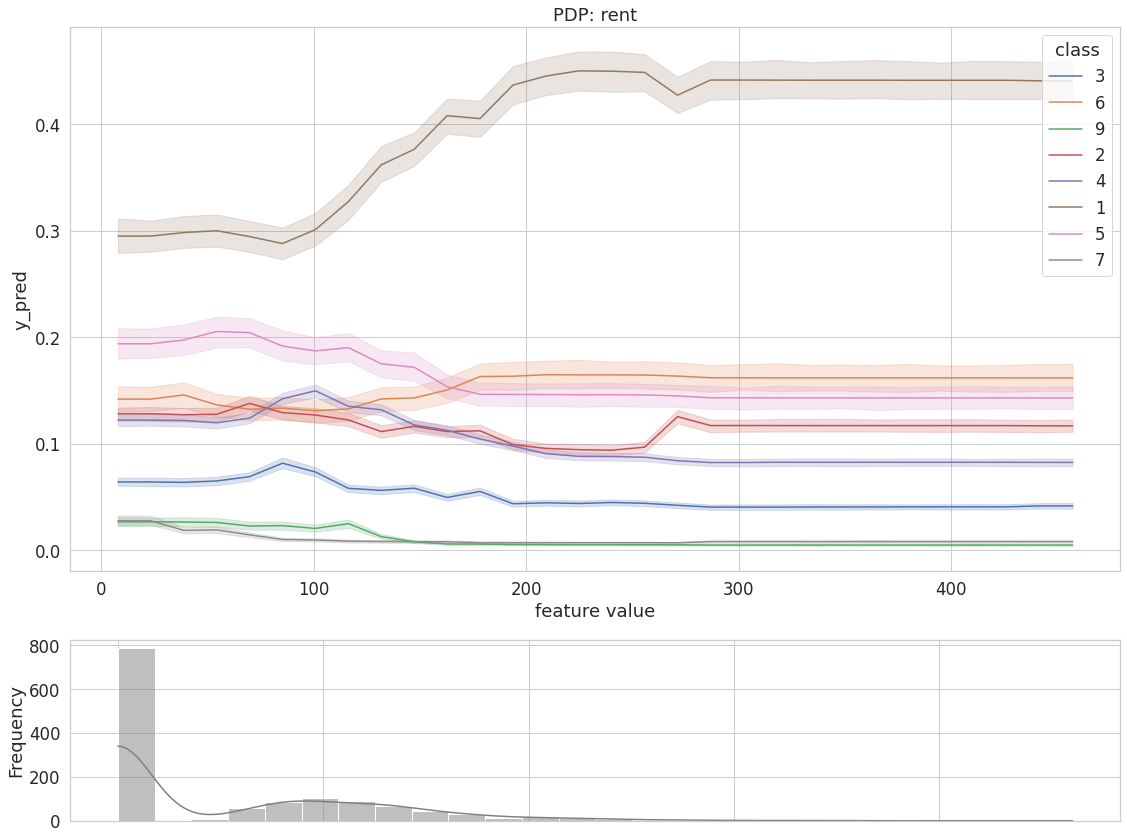

In [12]:
automl.plot_pdp(test_data, feature_name='rent')